This notebook includes all codes used for data preprocessing and exploratory data analysis of anti-Asian hate crimes in the US and Canada. A complete report with more details should refer to the pdf file named **"Qian_Assignment3_report"**.

In [1]:
#Part 1: data collection and preprocessing
import pandas as pd
import numpy as np
from datetime import datetime,date,timedelta
from covid19dh import covid19
# for Youtube dataset
import re
import html
import string
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download("wordnet")
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
#Part 2&3: data visualization
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import os
import itertools
from wordcloud import WordCloud

In [3]:
# settings
import warnings
warnings.filterwarnings("ignore")

# show plots inline for notebooks
%matplotlib inline

## 1. Data collection and preprocessing

### US Datasets

#### US dataset 1

In [4]:
#import dataset
hate_crime_US=pd.read_excel("datasets/US/Anti-Asian Hate crimes in US.xlsx")

In [5]:
hate_crime_US.head()

City        State  City Population  Total Hate Crimes 2019  \
0  New York City     New York          8336817                     428   
1    Los Angeles  California           3979537                     326   
2        Chicago     Illinois          2693959                     100   
3        Houston        Texas          2316797                      25   
4        Phoneix      Arizona          1680988                     156   

   Total Hate Crimes 2020 % of Change for Total Hate Crimes 2019-2020  \
0                   265.0                                       -0.38   
1                   355.0                                        0.09   
2                    81.0                                       -0.19   
3                    47.0                                        0.88   
4                   204.0                                        0.31   

   % of Population - AAPI Percent of Change Anti-Asian Hate Crimes (%)  \
0                   0.145                                         8.33   
1                   0.116                                         1.14   
2                   0.069                                            0   
3                   0.065                                            -   
4                   0.042                                          0.5   

   2019 Anti-Asian  2020 Anti-Asian  
0              3.0               28  
1              7.0               15  
2              2.0                2  
3              0.0                3  
4              2.0                3

In [6]:
#sum the total number of anti-Asian in 2019 and 2020 in the US
a= hate_crime_US["2019 Anti-Asian"].sum()
b= hate_crime_US["2020 Anti-Asian"].sum()
data = {'Country':['United States','United States'], 'Year': ['2019','2020'], 'Number of Anti-Asian': [a,b]}  
AAPI_US=pd.DataFrame(data)

In [7]:
AAPI_US

Country  Year  Number of Anti-Asian
0  United States  2019                  49.0
1  United States  2020                 120.0

#### US dataset 2

In [8]:
#import dataset
visible_increase_US_2020 = pd.read_excel("datasets/US/Stop Asian Hate dataset.xlsx",
                                sheet_name="Ethnicity of Respondents")

In [9]:
visible_increase_US_2020["Percent"]=visible_increase_US_2020["Percent"]*100

In [10]:
#show the ethnicity and the corresponding percent
visible_increase_US_2020.head(2)

Ethnicity of Respondents  Percent
0                  Chinese     40.4
1                   Korean     15.7

#### US dataset 3

In [11]:
#import gender dataset
gender_US = pd.read_excel("datasets/gender of respondents.xlsx",
                                sheet_name="Gender (US)")

In [12]:
gender_US.head(2)

Gender of Respondents  Percent
0                Female    0.695
1                  Male    0.291

## Canada datasets

#### Canada Dataset 1

In [13]:
#import police-reported hate crime in Canada in 2019
hate_crime_CA_2019=pd.read_csv("datasets/CA/police-reported hate crime in CA 2019.csv")

In [14]:
hate_crime_CA_2019.head(2)

Geography  Number of hate crime incidents  \
0    Total police-reported hate crime                            1946   
1  Total Non-Census metropolitan area                             319   

   Rate per 100,000 population  
0                          5.2  
1                          3.0

In [15]:
#Data preprocessing
hate_crime_CA_2019_1=pd.concat([hate_crime_CA_2019[['Number of hate crime incidents','Rate per 100,000 population']], 
                                hate_crime_CA_2019['Geography'].str.split(', ', expand=True)], axis=1)
hate_crime_CA_2019_1.rename(columns = {0: 'Region', 1: 'Province'}, inplace = True)
hate_crime_CA_2019_1 =hate_crime_CA_2019_1.iloc[3:]

In [16]:
hate_crime_CA_2019_1.head(2)

Number of hate crime incidents  Rate per 100,000 population  \
3                              14                          6.9   
4                               8                          3.1   

               Region          Province  
3  Abbotsford–Mission  British Columbia  
4              Barrie           Ontario

Note that Toronto, Montreal, Vancouver, Ottawa 

#### Canada dataset 2

In [17]:
#import dataset Source: Statistics Canada, Crowdsourcing on perceptions of safety, May 12-25, 2020
visible_increase_CA_2020 = pd.read_excel("datasets/CA/perceived frequency of harassment ot attack in CA (2020).xlsx",
                                sheet_name="Sheet2")

In [18]:
visible_increase_CA_2020.sort_values(by=['Percentage'],inplace=True,ascending=False)

In [19]:
visible_increase_CA_2020.head(2) #required to export dataset

Visible Minority Group  Percentage
0                Chinese        30.4
1                 Korean        27.0

#### Canada dataset 3

In [20]:
#import dataset
hate_type_CA19=pd.read_excel('datasets/CA/Number of hate crimes recorded by most serious violation.xlsx',
                                      sheet_name="Data")

In [21]:
hate_type_CA19.head()

Type of violation  Numer of crimes
0                                          Mischief              763
1                                  Assault, level 1              292
2                                  Uttering threats              290
3  Mischief to religious property motivated by hate              107
4           Assault, level 2, weapon or bodily harm              103

In [22]:
data2 = {'Country':['Canada','Canada'],'Year': ['2019','2020'], 'Number of Anti-Asian': [399,643]}  
AAPI_CA=pd.DataFrame(data2)

In [23]:
AAPI_CA

Country  Year  Number of Anti-Asian
0  Canada  2019                   399
1  Canada  2020                   643

#### Canada dataset 4 (COVID)

In [24]:
#import covid dataset in Canada from 2020-03-15 to 2020-03-30
coviddh2, src = covid19("CANADA", level = 2, start = date(2020,3,15),end=date(2021,3,30),verbose=False,vintage = True)

In [25]:
coviddh2.head()

id       date  vaccines  tests  confirmed  recovered  deaths  \
1999  015d95fc 2020-03-15       NaN    6.0        1.0        NaN     0.0   
2000  015d95fc 2020-03-16       NaN    6.0        1.0        NaN     0.0   
2001  015d95fc 2020-03-17       NaN   75.0        1.0        NaN     0.0   
2002  015d95fc 2020-03-18       NaN   75.0        1.0        NaN     0.0   
2003  015d95fc 2020-03-19       NaN   75.0        2.0        NaN     0.0   

      hosp  vent  icu  ...  administrative_area_level_1  \
1999   NaN   NaN  NaN  ...                       Canada   
2000   NaN   NaN  NaN  ...                       Canada   
2001   NaN   NaN  NaN  ...                       Canada   
2002   NaN   NaN  NaN  ...                       Canada   
2003   NaN   NaN  NaN  ...                       Canada   

      administrative_area_level_2  administrative_area_level_3  latitude  \
1999         Prince Edward Island                          NaN   46.5107   
2000         Prince Edward Island                          NaN   46.5107   
2001         Prince Edward Island                          NaN   46.5107   
2002         Prince Edward Island                          NaN   46.5107   
2003         Prince Edward Island                          NaN   46.5107   

      longitude  key   key_google_mobility    key_apple_mobility  key_numeric  \
1999   -63.4168  NaN  Prince Edward Island  Prince Edward Island          NaN   
2000   -63.4168  NaN  Prince Edward Island  Prince Edward Island          NaN   
2001   -63.4168  NaN  Prince Edward Island  Prince Edward Island          NaN   
2002   -63.4168  NaN  Prince Edward Island  Prince Edward Island          NaN   
2003   -63.4168  NaN  Prince Edward Island  Prince Edward Island          NaN   

      key_alpha_2  
1999          NaN  
2000          NaN  
2001          NaN  
2002          NaN  
2003          NaN  

[5 rows x 38 columns]

In [26]:
#selected the required column
covid_CA = coviddh2[["date","administrative_area_level_1","confirmed","deaths"]].reset_index()
covid_CA=covid_CA.drop(columns=["index"])

In [27]:
#create a variable called daily confirmed cases
covid_CA["Daily Positive Cases"]=covid_CA["confirmed"]-covid_CA["confirmed"].shift()
covid_CA["Daily Positive Cases"][0]=covid_CA["confirmed"][0]

In [28]:
#create a variable called daily deaths
covid_CA["Daily Deaths"]=covid_CA["deaths"]-covid_CA["deaths"].shift()
covid_CA["Daily Deaths"][0]=covid_CA["deaths"][0]

In [29]:
#rename the column
covid_CA=covid_CA.rename(columns={"date":"REPORT_DATE","administrative_area_level_1": "COUNTRY_SHORT_NAME"})

In [30]:
covid_CA.head(2)

REPORT_DATE COUNTRY_SHORT_NAME  confirmed  deaths  Daily Positive Cases  \
0  2020-03-15             Canada        1.0     0.0                   1.0   
1  2020-03-16             Canada        1.0     0.0                   0.0   

   Daily Deaths  
0           0.0  
1           0.0

#### Canada dataset 5

In [31]:
#import dataset
gender_CA = pd.read_excel("datasets/gender of respondents.xlsx",
                                sheet_name="Gender (CA)")

In [32]:
gender_CA.head(2)

Gender of Respondents  Percent
0                Female   0.5922
1                  Male   0.3570

Take average on the percentage of gender of respondents in both countries

In [33]:
#import dataset
gender_NA = pd.read_excel("datasets/gender of respondents.xlsx",
                                sheet_name="Gender (Average)")

### Youtube datasets

In [34]:
#import Youtube datasets
youtube_2019=pd.read_excel("datasets/Youtube/2019-videolist_search.xlsx")
youtube_2020=pd.read_excel("datasets/Youtube/2020-videolist_search.xlsx")
youtube_2021=pd.read_excel("datasets/Youtube/2021-videolist_search.xlsx")

In [35]:
youtube_2019.columns

Index(['position', 'channelId', 'channelTitle', 'videoId', 'publishedAt',
       'publishedAtSQL', 'videoTitle', 'videoDescription', 'tags',
       'videoCategoryId', 'videoCategoryLabel', 'duration', 'durationSec',
       'dimension', 'definition', 'caption', 'thumbnail_maxres',
       'licensedContent', 'viewCount', 'likeCount', 'dislikeCount',
       'favoriteCount', 'commentCount'],
      dtype='object')

In [36]:
#select the required columns
description_2019=youtube_2019[["videoTitle","videoDescription"]]
description_2020=youtube_2020[["videoTitle","videoDescription"]]
description_2021=youtube_2021[["videoTitle","videoDescription"]]

In [37]:
#change the variable to string
description_2019["videoDescription"]=description_2019["videoDescription"].astype(str).str.replace('/',' ')
description_2020["videoDescription"]=description_2020["videoDescription"].astype(str).str.replace('/',' ')
description_2021["videoDescription"]=description_2021["videoDescription"].astype(str).str.replace('/',' ')

In [38]:
#change the variable to string
description_2019["videoTitle"]=description_2019["videoTitle"].astype(str).str.replace('/',' ')
description_2020["videoTitle"]=description_2020["videoTitle"].astype(str).str.replace('/',' ')
description_2021["videoDescription"]=description_2021["videoTitle"].astype(str).str.replace('/',' ')

#### Data cleaning

In [39]:
#Remove all html tags and attributes
def parse(text):
    text = re.sub(re.compile("/<[^>]+>/"),"",text)
    return text

# Html character codes (i.e., &...;) are replaced with an ASCII equivalent
def to_ascii(text):
    text = html.unescape(text)
    return text

#Lower case
def lower_case(text):
    return text.lower()

#Remove urls
def remove_urls(text):
    text = re.sub(r"http\S+", "", text, flags=re.MULTILINE)
    return text

# Remove non-alphabetic words, whitespaces and puctuation
def remove_noletter_ws_puc(text):
    try: 
        text = re.sub(re.compile(r"[^A-Za-z]+"), " ",text) #remove non-letter
        text = re.sub(re.compile(r'\s+')," ",text) #remove whitespaces
        text = text.translate(string.maketrans("",""), string.punctuation) #remove punctuation
    except:
        text=text
    return text

# Remove all stop words
stopword = stopwords.words('english')
def remove_stopwords(text):
    word=text.split()
    text=" ".join([temp for temp in word if temp not in stopword])
    return text

#Lemmatization
lm=WordNetLemmatizer()

In [40]:
#Apply the functions to video title
description_2019["cleaned_text"]=description_2019["videoTitle"].apply(parse)
description_2019["cleaned_text"]=description_2019["cleaned_text"].apply(to_ascii)
description_2019["cleaned_text"]=description_2019["cleaned_text"].apply(lower_case)
description_2019["cleaned_text"]=description_2019["cleaned_text"].apply(remove_urls)
description_2019["cleaned_text"]=description_2019["cleaned_text"].apply(remove_noletter_ws_puc)
description_2019["cleaned_text"]=description_2019["cleaned_text"].apply(remove_stopwords)
description_2019["cleaned_text"]=description_2019["cleaned_text"].apply(lambda y: " ".join([lm.lemmatize(w,"v")
                                                                                            for w in y.split()]))

In [41]:
#same step for 2020 dataset
description_2020["cleaned_text"]=description_2020["videoTitle"].apply(parse)
description_2020["cleaned_text"]=description_2020["cleaned_text"].apply(to_ascii)
description_2020["cleaned_text"]=description_2020["cleaned_text"].apply(lower_case)
description_2020["cleaned_text"]=description_2020["cleaned_text"].apply(remove_urls)
description_2020["cleaned_text"]=description_2020["cleaned_text"].apply(remove_noletter_ws_puc)
description_2020["cleaned_text"]=description_2020["cleaned_text"].apply(remove_stopwords)
description_2020["cleaned_text"]=description_2020["cleaned_text"].apply(lambda y: " ".join([lm.lemmatize(w,"v")
                                                                                            for w in y.split()]))

In [42]:
#same step for 2021 dataset
description_2021["cleaned_text"]=description_2021["videoTitle"].apply(parse)
description_2021["cleaned_text"]=description_2021["cleaned_text"].apply(to_ascii)
description_2021["cleaned_text"]=description_2021["cleaned_text"].apply(lower_case)
description_2021["cleaned_text"]=description_2021["cleaned_text"].apply(remove_urls)
description_2021["cleaned_text"]=description_2021["cleaned_text"].apply(remove_noletter_ws_puc)
description_2021["cleaned_text"]=description_2021["cleaned_text"].apply(remove_stopwords)
description_2021["cleaned_text"]=description_2021["cleaned_text"].apply(lambda y: " ".join([lm.lemmatize(w,"v")
                                                                                            for w in y.split()]))

## 2. Data visualization: Comparisons towards hate crimes against Asians in the US and Canada

### Visualization 1:  2019 Top 4 cities with the highest cumulative hate crimes in the US and Canada

#### US visualization 1. 2019 Top 4 cities with the highest cumulative hate crimes in the US

In [43]:
total_US = hate_crime_US.copy()
total_US.sort_values(by=['Total Hate Crimes 2019'],inplace=True,ascending=False)## Represent only large states
total_US_top=total_US.head(4) #only show the top 4 cities

In [44]:
fig = px.bar(total_US_top,x="City", y='Total Hate Crimes 2019', 
             title='2019 Top 4 cities with the highest cumulative hate crimes in the US', 
             text="Total Hate Crimes 2019",height=600,
            color="Total Hate Crimes 2019",color_continuous_scale=px.colors.sequential.Redor)
fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

#### CA Visualization 1. 2019 Top 4 regions with the highest cumulative hate crimes in Canada

In [45]:
total_CA = hate_crime_CA_2019_1.copy()
total_CA.sort_values(by=['Number of hate crime incidents'],inplace=True,ascending=False)## Represent only large states
total_CA_top=total_CA.head(4) #only show the top 4 cities

In [46]:
fig = px.bar(total_CA_top,x="Region", y='Number of hate crime incidents', 
             title='2019 Top 4 regions with the highest cumulative hate crimes in Canada', 
             text="Number of hate crime incidents",height=600,
            color="Number of hate crime incidents",color_continuous_scale=px.colors.sequential.Teal)
fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

### Visualization 2: Prejudice Incidents Rate tageting US and Canada Populations by Victim Ethnicity in 2020

In [47]:
fig = go.Figure(data=[
    go.Bar(name='US', x=visible_increase_US_2020['Ethnicity of Respondents'], y=visible_increase_US_2020['Percent']),
    go.Bar(name='CA', x=visible_increase_CA_2020['Visible Minority Group'], y=visible_increase_CA_2020['Percentage'])])

fig.update_layout(barmode='group',xaxis={'categoryorder':'total ascending'},
                 title="Prejudice Incidents Rate tageting US and Canada Populations by Victim Ethnicity in 2020")
fig.show()

### Visualization 3: Number of Anti Asian Hate Crimes in 2019 and 2020

In [48]:
#combine dataset together
AAPI_US_CA =pd.concat([AAPI_US,AAPI_CA])

In [49]:
fig = px.line(AAPI_US_CA, x="Year", y='Number of Anti-Asian',color='Country',
             title='Number of Anti Asian Hate Crimes (2019-2020)',
             width=600, height=450,text="Number of Anti-Asian")
fig.show()

### Visualization 4: Gender of Respondents in US and Canada (2020)

In [50]:
fig = make_subplots(1, 2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['US', 'Canada'])
fig.add_trace(go.Pie(labels=gender_US["Gender of Respondents"], values=gender_US["Percent"], scalegroup='one',
                     name="World GDP 1980"), 1, 1)
fig.add_trace(go.Pie(labels=gender_CA["Gender of Respondents"], values=gender_CA["Percent"], scalegroup='one',
                     name="World GDP 2007", marker_colors=px.colors.sequential.tempo), 1, 2)

fig.update_layout(title_text='Gender of Respondents in US and Canada (2020)')
fig.show()

In [51]:
fig = px.pie(gender_NA, values='Percent', names='Gender of Respondents', 
             color_discrete_sequence=px.colors.sequential.Burgyl, 
             title ='Gender of Respondents in North America (2020)', width=600, height=450)
fig.show()

### 3. Data Visualization: Word clouds of Youtube datasets

In [52]:
unique_string_2019=(" ").join(description_2019["cleaned_text"])
unique_string_2020=(" ").join(description_2020["cleaned_text"])
unique_string_2021=(" ").join(description_2021["cleaned_text"])

#### 2019 visualization

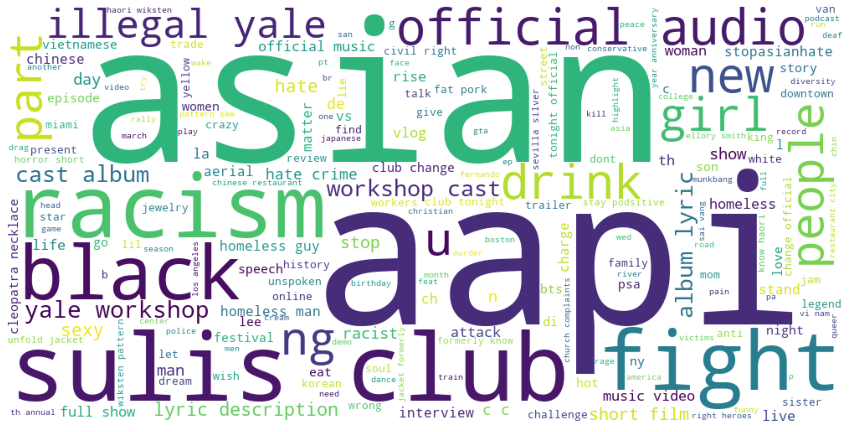

In [53]:
wordcloud = WordCloud(width = 1000, height = 500,background_color='white').generate(unique_string_2019)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

#### 2020 visualization

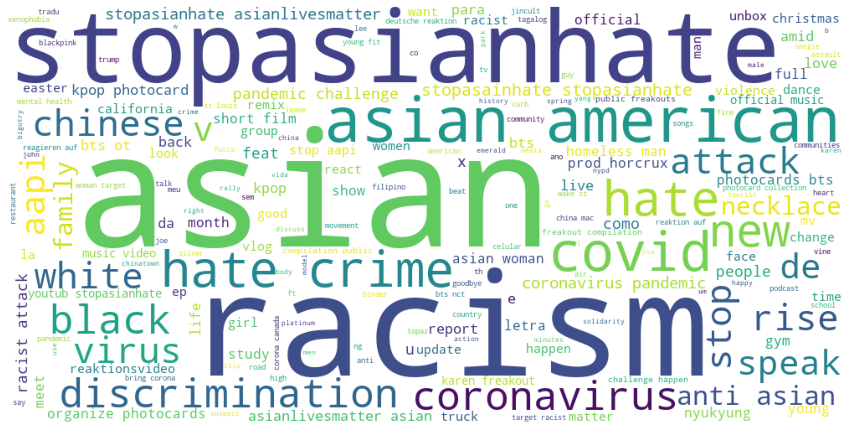

In [54]:
wordcloud = WordCloud(width = 1000, height = 500,background_color='white').generate(unique_string_2020)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

#### 2021 visualization

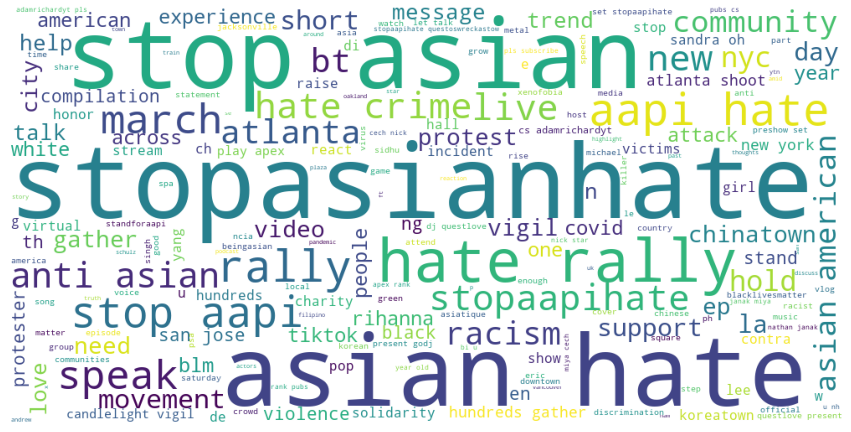

In [55]:
wordcloud = WordCloud(width = 1000, height = 500,background_color='white').generate(unique_string_2021)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

### 4. Aggregate and Export the datasets

#### US and Canada datasets

In [56]:
#export dataset
#hate_crime_CA_2019_1.to_excel(r'datasets/hate_crime_CA_2019.xlsx',index=False)
#covid_CA.to_csv(r'datasets/covid_CA.csv')
#total_CA_top= total_CA_top.reset_index()
#total_CA_top.to_csv(r'datasets/total_CA_top.csv')
#AAPI_US_CA.to_csv(r'datasets/AAPI_US_CA.csv')

#### Youtube datasets

In [57]:
#count the frequency of words
word_frequency_2019 = description_2019["cleaned_text"].str.split(expand=True).stack().value_counts()
word_frequency_2019=word_frequency_2019.rename_axis('Word').reset_index(name='Score')
word_frequency_2019["Category"]=2019

In [58]:
word_frequency_2019.head()

Word  Score  Category
0      aapi     49      2019
1     asian     36      2019
2  official     25      2019
3      club     22      2019
4     sulis     21      2019

In [59]:
wf_2019=word_frequency_2019.head(20) #only select the top 20 most frequent words

In [60]:
word_frequency_2020 = description_2020["cleaned_text"].str.split(expand=True).stack().value_counts()
word_frequency_2020=word_frequency_2020.rename_axis('Word').reset_index(name='Score')
word_frequency_2020["Category"]=2020

In [61]:
word_frequency_2020.head()

Word  Score  Category
0          asian     88      2020
1  stopasianhate     61      2020
2           hate     43      2020
3         racism     40      2020
4          covid     27      2020

In [62]:
wf_2020=word_frequency_2020.head(20)

In [63]:
word_frequency_2021 = description_2021["cleaned_text"].str.split(expand=True).stack().value_counts()
word_frequency_2021=word_frequency_2021.rename_axis('Word').reset_index(name='Score')
word_frequency_2021["Category"]=2021

In [64]:
word_frequency_2021.head()

Word  Score  Category
0          asian    272      2021
1           hate    262      2021
2  stopasianhate    255      2021
3           stop    248      2021
4          rally     74      2021

In [65]:
wf_2021=word_frequency_2021.head(20)

In [66]:
word_frequency=pd.concat([wf_2019,wf_2020,wf_2021])

In [67]:
word_frequency=word_frequency.reset_index()

In [68]:
word_frequency.head()

index      Word  Score  Category
0      0      aapi     49      2019
1      1     asian     36      2019
2      2  official     25      2019
3      3      club     22      2019
4      4     sulis     21      2019

export dataset as a csv file

In [69]:
#word_frequency.to_csv(r'datasets/word_frequency.csv')